<h1><center> Baseball Performance Metrics and Salary Analysis</center></h1>

<h3><center> Udacity Data Analysis Nanodegree Project 2</center></h3>

### Introduction

Since the publication of Michael Lewis's _Moneyball_ in 2003, there has been an explosion in interest in the field of [sabermetrics](http://sabr.org/sabermetrics), the application of empirical methods to baseball statistics. Teams looking for an edge have increasingly turned to analysis of all manner of player statistics, from the easy to understand home runs, to the exceedingly complex, such as weighted runs created and fielding independent pitching. The main goal of these efforts have been to identify players with high performance potential who may have flown under the radar and thus will not command as astronomical of a salary as more well-known names. For this analysis, I performed my own introductory sabermetrical excursion into the world of baseball statistics, although I stuck to more familiar baseball metrics for hitting and pitching such as [Runs Batted In (RBI)](http://m.mlb.com/glossary/standard-stats/runs-batted-in) and [Earned Run Average (ERA)](http://m.mlb.com/glossary/standard-stats/earned-run-average). In particular, I was interested in the relationship or lack there of between various performance metrics for batting and pitching and player salaries. I wanted to determine which batting and pitching stats were most strongly correlated with salaries and why that might be so. However, I wanted to go further and examine a player's change in performance metrics over seasons and how that may be related to the salary he earned. Therefore, the approach I took was to examine a single season of salaries, from 2008, and look at the hitting and pitching data from not only that year, but from the preceding two seasons (2006, 2007) and the following two seasons (2009, 2010). I had several questions about the data that I would seek to answer:

1. Which batting statistic, hits, home runs, or runs batted in, had the highest correlation with player salary?
2. Which pitching statistic, earned run average, wins, or strikeouts, had the highest correlation with pitcher salary?
3. Are these correlations higher in the two seasons preceding the salary year, or in the two seasons following the salary year?
4. What can these correlations tell us about relative player value?

I formed a hypothesis about each question based on my rudimentary baseball knowledge and I was well-prepared to accept conclusions that went against my pre-conceived notions.
My four hypotheses were as follows:

1. Home runs will be the most highly correlated statistic with batter salary. I thought that since home runs were a "flashier" statistic, the public at large, and more importantly, the owners of the teams that pay the salaries, would reward batters who displayed a greater tendency to go long. 
2. Similar to my reasoning for 1, I thought that wins would most highly correlate with pitcher salary as they are easily understood and it seems "fair" to reward pitchers who produce more wins for their team [regardless of how representative a measure of a pitcher's effectiveness wins may be](http://bleacherreport.com/articles/642360-mlb-why-wins-are-an-insignificant-and-irrelevant-pitching-statistic). 
3. The correlations between performance metrics and salaries will be higher in the preceding two seasons than in the following two seasons. Players who had two good years would be rewarded with a high salary in 2008, but then they would [regress to the mean](http://rationalwiki.org/wiki/Regression_to_the_mean) in the following two seasons. A player with two outstanding seasons may seem destined to have a streak of stellar years, but like many other aspects of human performance, baseball is inherently random, which means that outliers will tend to drift back towards the center over time. 
4. Based on 3, teams should not look to sign players who are coming off multiple good years, but should instead try to discover players on the cusp of a breakout season. On the other hand, players who commanded a large salary in previous years should not be worth as much in subsequent seasons and teams would be wise to avoid them. 

The data I used for my analysis is from http://www.seanlahman.com/baseball-archive/statistics/ and the description of the various stats contained are at http://seanlahman.com/files/database/readme58.txt. I used the 2016 version of the batting, pitching, and salary datasets downloaded as comma separated value (csv) files. Any sources I consulted during the creation of this report will be linked to in the text. 

### Data Wrangling

In [1]:
# Standard data analysis imports with quandl used for financial data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import quandl
import seaborn as sns
import math

In [2]:
# These are the DataFrames containing the raw data as provided by Sean Lahman
all_salaries = pd.read_csv('Salaries.csv')
all_batting = pd.read_csv('Batting.csv')
all_pitching = pd.read_csv('Pitching.csv')

I first needed to get a feel for the data I was going to be analyzing. I took a look through the raw data and made a few preliminary observations, such as the lack of data for the earliest years in the sets. This informed my decision to concentrate on salaries from 2008, and statistics from the period 2006-2010. Out of curiousity, I decided to graph the average salary of all Major League Baseball (MLB) players as a percentage change over time (from 1985) and then compared that to the median household income percentage change in the United States using data from [Quandl](https://www.quandl.com/).

Populating the interactive namespace from numpy and matplotlib


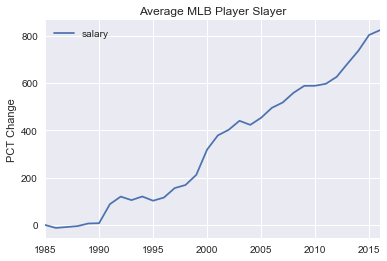

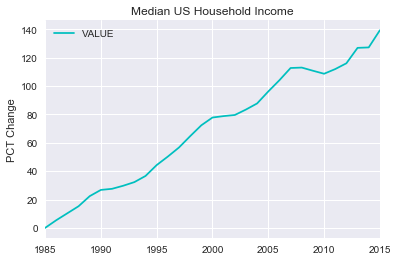

In [3]:
# Set up pylab to run in the Jupyter Notebook
%pylab inline

# Group the salaries by mean 
yearly_average_salary = all_salaries.groupby('yearID').mean()

# Calculate and plot the percentage change from the first entry
yearly_salary_pct_change = 100.0 *  (yearly_average_salary - yearly_average_salary.iloc[0]) / yearly_average_salary.iloc[0]
yearly_salary_pct_change.plot()
plt.title('Average MLB Player Slayer')
plt.ylabel('PCT Change'); plt.xlabel('')

# Retrieve data from Quandl with the start date that corresponds to the MLB salary start date
median_household_income = quandl.get('FRED/MEHOINUSA646N', start_date = '1985-01-01')

# Calculate and plot the percentage change of median household income from the first entry
median_household_pct_change = 100.0 * (median_household_income - median_household_income.iloc[0]) / median_household_income.iloc[0]
median_household_pct_change.plot(color = 'c')
plt.title('Median US Household Income')
plt.ylabel('PCT Change'), plt.xlabel('');

While both the median United States household income and MLB player salary have increased over time, MLB salaries have far outpaced the growth of all US salaries. MLB salaries have grown by about 800% in only 40 years! That is an annual inflation rate of 5.3% compared to only 0.84% for the general public. Clearly, MLB players must be working wonders to deserve such lucrative contracts.

In [4]:
# I am only concerned with salaries in the year 2008. I don't need to know the teams or the league of the player.
salaries_2008 = all_salaries[all_salaries['yearID']==2008]
salaries_2008 = salaries_2008.drop(['yearID', 'teamID', 'lgID'], axis=1)

As I was concerned with 2008 salaries, I thought it would be helpful to get a sense of the scale of what players were paid in that season. A histogram was the best way to demonstrate that the majority of players are clustered around the same pay, with a positively skewed distribution demonstrating several significant outliers. Make sure to note that the x-axis is in millions of US dollars. 

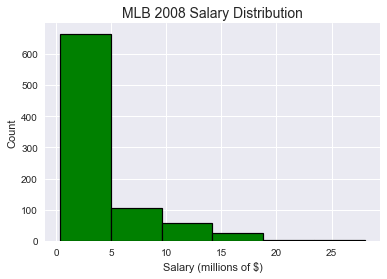

In [5]:
# Create a histogram salaries from 2008.
plt.hist((salaries_2008['salary']/1e6), bins=6, color='g', edgecolor='black', linewidth=1.2, align='mid');
plt.xlabel('Salary (millions of $)'), plt.ylabel('Count')
plt.title('MLB 2008 Salary Distribution', size = 14);

In [6]:
# Modify the all_batting DataFrame to contain only the statistics I want to examine:
# For batting these are: Runs Batted In (RBI), Hits (H), Home Runs (HR)
# Moreover, I only want to examine the 5 year period around the salary year [2006-2010]

years_to_examine = [2006, 2007, 2008, 2009, 2010]
batting = all_batting[['playerID', 'yearID', 'RBI', 'H', 'HR', 'G']]
batting = batting[batting['yearID'].isin(years_to_examine)]

In [7]:
# For pitching, the relevant statistics are: Earned Run Average (ERA), Wins (W), and Stikeouts (SO)

pitching = all_pitching[['playerID', 'yearID', 'ERA', 'W', 'SO', 'IPouts']]
pitching = pitching[pitching['yearID'].isin(years_to_examine)]

In [8]:
# Examine the data so far.
batting.tail(15)

,playerID,yearID,RBI,H,HR,G
94191,youngch04,2010,91.0,150,27,156
94192,youngde03,2010,112.0,170,21,153
94193,youngde04,2010,28.0,45,7,110
94194,younger03,2010,8.0,42,0,51
94195,youngmi02,2010,91.0,186,21,157
94196,zagurmi01,2010,0.0,0,0,8
94197,zambrca01,2010,6.0,12,1,42
94198,zaungr01,2010,14.0,27,2,28
94199,zawadla01,2010,1.0,7,0,20
94200,zieglbr01,2010,0.0,0,0,64


I see that the indexes of the DataFrames are the row numbers from the csv file. That does not really bother me at this point because I am not using the index values for any analysis

In my initial examination of the raw data, I observed that some player IDs had multiple entires in the same year. Looking at the source data more closely, I saw that was because these players had multiple stints recorded in the same season. That is, they started the season with one team, were traded to another team, and had played a full season across two or more different teams. I wanted to include these players in my analysis, so I grouped the data by player and year, and summed up the statistics for players who had multiple entries in the same year to compress their statistics into a single figure for the season. This did not affect my analysis as I was not concerned with the teams players were on when they compiled their figures. 

In [9]:
batting = batting.groupby(['playerID', 'yearID'], as_index=False).sum()
pitching = pitching.groupby(['playerID', 'yearID'], as_index=False).sum()

It looks like I have a decent start, but there are still several issues with the data. One is that I only want to analyze players who were able to play a full season in each of the years under consideration. This was in order to exclude players who may have been injured but still received a salary and would thus affect the average of the performance metrics (a player with 0 hits but a \$10 million salary would have quite the effect on the data!). After doing some research on http://www.fangraphs.com/, I decided that a decent metric to quantify a full season would be 100 games per season for the batters and 120 innings pitched per season for the pitchers. I decided to limit the analysis to starting pitchers and not relievers or closers and this bar for pitchers would take care of that issue as well. 

In [10]:
# Removing any records with fewer than 100 games for batters and 120 innings pitched for pitchers.
batting = batting[batting['G'] > 100]
pitching = pitching[(pitching['IPouts'] / 3) > 120]

Another primary issue with the data was that at this point it contained players who had even a single record for any of the five years [2006-2010]. I only wanted players who had records in every year in the range in order to track the same players across multiple seasons. I decided to write a function that could take in the batting and pitching DataFrames, and return DataFrames with only players who played in all five years. 

In [11]:
'''
The batting and pitching DataFrames currently contain all players with even a single year in the five-year range.
I need to remove the players who do not have records across all five seasons. In order to do so, I wrote a function that 
takes in a DataFrame, and returns the DataFrame modified to only contain players with five entries. At this point, there
are no players who have multiple entries for the same year, so checking the number of times a given playerID occurs in the 
playerID column is the quickest way to create the DataFrame I want. 
'''

def find_players_with_all_years(records):
    
    # First create a list with all of the playerIDs (many will be repeated) in the playerID column of the DataFrame
    list_of_IDs = list(records['playerID'])
    players_with_five_years = set()
    
    # Iterate through the list of IDs and count how many times a given ID occurs in the list
    # This will correspond to the number of entries that player has in the records_df
    for player in list_of_IDs:
        if (list_of_IDs.count(player)) == len(years_to_examine):
            players_with_five_years.add(player)
    
    # Return a modified DataFrame that only includes players with records in every year in the range of years to examine
    return records[records['playerID'].isin(players_with_five_years)]


In [12]:
# Create the new DataFrames including only players with records in years in the analysis
batting = find_players_with_all_years(batting)
pitching = find_players_with_all_years(pitching)

At this point I want to be sure that my DataFrames contain exactly what I want. The next few cells are checks to examine the DataFrames and make sure that the code has modified the data as intended. 

In [13]:
pitching.head(16)

,playerID,yearID,ERA,W,SO,IPouts
64,arroybr01,2006,3.29,14,184,722
65,arroybr01,2007,4.23,9,156,632
66,arroybr01,2008,4.77,15,163,600
67,arroybr01,2009,3.84,15,127,661
68,arroybr01,2010,3.88,17,121,647
166,beckejo02,2006,5.01,16,158,614
167,beckejo02,2007,3.27,20,194,602
168,beckejo02,2008,4.03,12,172,523
169,beckejo02,2009,3.86,17,199,637
170,beckejo02,2010,5.78,6,116,383


In [14]:
player_counts = []
for playerID in batting['playerID']:
    player_counts.append(list(batting['playerID']).count(playerID))
    
print('The average number of times a playerID appears in the batting DF is {:0.4f}'.format(np.mean(player_counts)))

The average number of times a playerID appears in the batting DF is 5.0000


In [15]:
player_counts = []
for playerID in batting['playerID']:
    player_counts.append(list(batting['playerID']).count(playerID))
    
print('The average number of times a playerID appears in the pitching DF is {:0.4f}'.format(np.mean(player_counts)))

The average number of times a playerID appears in the pitching DF is 5.0000


Given that the mean number of appearances of each player ID in the pitching and batting DataFrames was 5.0, I am confident my DataFrames correctly represent the data. They include only players with records in all years as well as only the players who meet the games played or innings pitched cut-offs for batters and pitchers respectively.

I now want to include the salaries in the DataFrame. This will put in the same 2008 salary for all five years, which is fine at this point as the averaging will simply return the 2008 salary.

In [16]:
# Merge the salary and performance statistics DataFrames. This will add a column with the salary to the DataFrames. 
batting = batting.merge(salaries_2008, on='playerID')
batting = batting.rename(columns = {'H': 'Hits', 'HR': 'Home Runs', 'G': 'Games', 'salary' : 'Salary'})

In [17]:
pitching = pitching.merge(salaries_2008, on='playerID')
pitching = pitching.rename(columns = {'W':'Wins', 'SO':'Strikeouts', 'salary': 'Salary'})

I now want to create three separate DataFrames in order to make comparisons between performance and salary over time:
1. An average of statistics over the entire five seasons [2006-2010]
2. An average of statistics over the two seasons before the salary year [2006-2007]
3. An average of statistics over the two seasons after the salary year [2009-2010]

In [18]:
previous_years = [2006, 2007]
following_years = [2009, 2010]

# This function takes in the DataFrames with records for all five years and creates three separate DataFrames
def create_seasons_averages(records):
    
    # I found that the easiest way to create the DataFrames was to group by playerID and average the statistics over the years
    five_year_average = records.groupby('playerID', as_index=False).mean()
    
    previous_two_years = records[records['yearID'].isin(previous_years)]
    previous_two_years_average = previous_two_years.groupby('playerID', as_index=False).mean()
    
    following_two_years = records[records['yearID'].isin(following_years)]
    following_two_years_average = following_two_years.groupby('playerID', as_index=False).mean()
    
    # The three DataFrames returned are as specified above. 
    return five_year_average , previous_two_years_average, following_two_years_average

In [19]:
# Create the average batting and pitching DataFrames
batting_five_year, batting_previous, batting_following  = create_seasons_averages(batting)
pitching_five_year, pitching_previous, pitching_following = create_seasons_averages(pitching)

The next cell provides me with the number of batters and pitchers I am dealing with who meet the criteria I specified.

In [20]:
print('There are {} batters in the wrangled batting datasets.'.format(len(batting_previous)))

print('There are {} pitchers in the wrangled pitching datasets.'.format(len(pitching_previous)))

There are 83 batters in the wrangled batting datasets.
There are 32 pitchers in the wrangled pitching datasets.


As a final step, I can drop the yearID from all the DataFrames. I want to keep the playerID because I will use it to compare player's statistics across seasons. 

In [21]:
df_list = [ batting_five_year, batting_previous, batting_following, \
            pitching_five_year, pitching_previous, pitching_following]

# This function takes in a list of DataFrames and drops the yearID column from all of them
def drop_year_and_player_ID(df_list):
    for df in df_list:
        df.is_copy = False
        df.drop(['yearID'] , axis=1, inplace=True)

In [22]:
drop_year_and_player_ID(df_list)

I want to look at a couple of my DataFrames at this point to make sure they are correct.

In [23]:
batting_following.head(10)

,playerID,RBI,Hits,Home Runs,Games,Salary
0,abreubo01,90.5,155.5,17.5,153.0,16000000.0
1,bautijo02,82.0,113.5,33.5,137.0,1800000.0
2,beltrad01,73.0,154.0,18.0,132.5,13400000.0
3,berkmla01,69.0,113.0,19.5,129.0,14500000.0
4,betanyu01,63.5,129.5,11.0,142.5,1550000.0
5,blakeca01,71.5,131.0,17.5,142.5,6100000.0
6,burrepa01,64.0,92.5,17.0,121.0,14250000.0
7,cabreme01,55.0,125.0,8.5,150.5,461200.0
8,cabremi01,114.5,189.0,36.0,155.0,11300000.0
9,cabreor01,59.5,158.0,6.5,141.5,10000000.0


In [24]:
pitching_previous.head(10)

,playerID,ERA,Wins,Strikeouts,IPouts,Salary
0,arroybr01,3.760,11.5,170.0,677.0,4575000.0
1,beckejo02,4.140,18.0,176.0,608.0,10166666.0
2,blantjo01,4.385,15.0,123.5,636.5,3700000.0
3,buehrma01,4.310,11.0,106.5,607.5,14000000.0
4,burneaj01,3.865,10.0,147.0,452.0,13200000.0
5,cainma01,3.900,10.0,171.0,586.0,950000.0
6,cookaa01,4.175,8.5,76.5,568.0,5125000.0
7,garlajo01,4.370,14.0,105.0,629.5,12000000.0
8,hallaro01,3.450,16.0,135.5,668.0,10000000.0
9,hamelco01,3.735,12.0,161.0,473.5,500000.0


I finally have the data wrangled in the format I want! It's time to start the analysis. The driving motivation behind the analysis will be the four questions I posed in the introduction. As a quick reminder, I will be looking at which statistics correlatate most highly with salary for both batters and pitchers, and then I will look at how these correlations change over time. I will look at how the performance metrics and salary correlations differ between the entire five-year range, the two seasons preceding the salary year, and the two seasons following the salary year. 

### Performance Metric and Salary Analysis

The batters will lead-off the analysis (pun totally intended) and I will look at which stats from the entire five-year average are most highly correlated with the salary in 2008. 

#### Batting Analysis

In [25]:
'''
This function takes in a DataFrame and a list of statistics and plots the relationship 
between each statistic and the salary in a scatter plot. It also draws in the best fit line
for the data using numpy\'s polyfit method. Finally, it prints the Pearson's correlation correlation
coefficient between each statistic and the salary. The graph formatting and the print output are 
specific to the five-year records.
'''

def analyze_five_year_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6 
        plt.figure()
        plt.scatter(x,y)
        plt.title('Five-Year Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the five years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()[statistic]['Salary']))

The correlation between average RBI over the five years and salary is 0.344
The correlation between average Hits over the five years and salary is 0.238
The correlation between average Home Runs over the five years and salary is 0.299


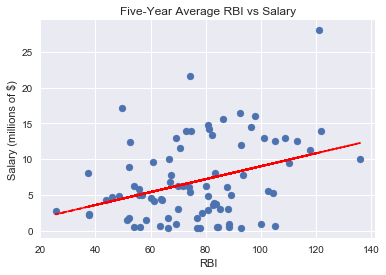

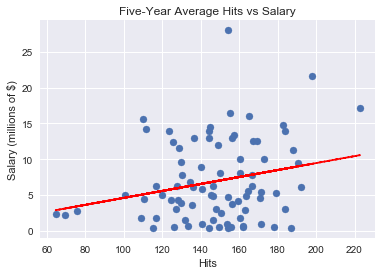

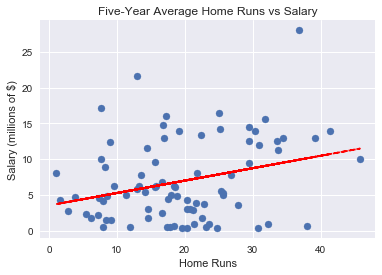

In [26]:
analyze_five_year_records(batting_five_year, ['RBI', 'Hits', 'Home Runs'])

The correlation number returned is the [Pearson correlation coefficient](http://www.statisticshowto.com/what-is-the-pearson-correlation-coefficient/), a measure of how linearly dependent two variables are to one another. The coefficient value is between -1 and +1, and two variables that are perfectly correlated with have a value of +1. It is premature to draw absolute conclusions using only the correlation coefficient as what constitutes a strong vs weak correlation depends heavily on the field of study, the instruments used to record the measurements, and the variables themselves. However, I am using the correlation coefficient in relative terms in this analysis to determine whether one correlation is stronger than another. Based on this measure, for the entire five-year interval, runs batted in (RBI) has the highest correlation with salary followed by home runs and then hits. That is counter to my initial hypothesis that home runs would have the strongest correlation with salary. All three of the performance metrics were positively correlated with salary, indicating that players who perform better over the long term do in fact tend to be more highly compensated. 

The next step for this analysis was to determine whether these correlations would be stronger for the preceding seasons or for the following seasons.

In [27]:
# This function does the same job as the five-year analyze function but the output is tailored to the previous seasons. 
def analyze_previous_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6
        plt.figure()
        plt.scatter(x,y)
        plt.title('Previous Two Seasons Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the previous two years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()['Salary'][statistic]))

The correlation between average RBI over the previous two years and salary is 0.462
The correlation between average Hits over the previous two years and salary is 0.332
The correlation between average Home Runs over the previous two years and salary is 0.396


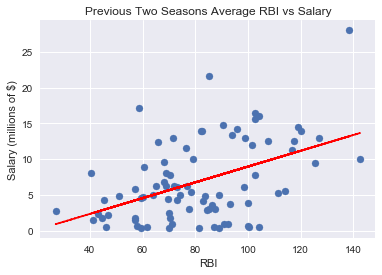

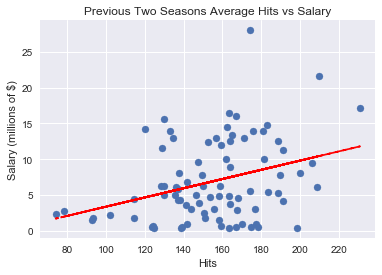

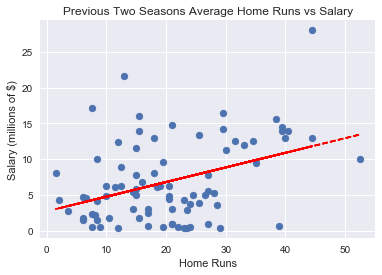

In [28]:
analyze_previous_records(batting_previous, ['RBI', 'Hits', 'Home Runs'])

The correlation between the average performance metrics from the previous two years and salary is greater than that between the average performance metrics over the entire five years and salary. This suggests that players are indeed rewarded for above average performances in preceding seasons. That is, players who perform well for several years will then be more likely to command a high salary in the subsequent year.

Next, we can look at the two seasons following the salary to see if the correlations remain. My guess is the correlation between the performance metrics and the salary will not be as strong in the following years because the players will not be able to maintain their high level of play that earned them the larger salary in the first place. 

In [29]:
# Same analysis and plotting function but tailored to the following seasons. 
def analyze_following_records(record_df, statistics_list):
    for statistic in statistics_list:
        x = record_df[statistic]
        y = record_df['Salary'] / 1e6
        plt.figure()
        plt.scatter(x,y)
        plt.title('Following Two Seasons Average {} vs Salary'.format(statistic))
        plt.ylabel('Salary (millions of $)')
        plt.xlabel('{}'.format(statistic))
        z = numpy.polyfit(x, y, 1)
        p = numpy.poly1d(z)
        plt.plot(x, p(x), 'r--')
        print('The correlation between average {} over the following two years and salary is {:0.3f}' \
         .format(statistic, record_df.corr()['Salary'][statistic]))

The correlation between average RBI over the following two years and salary is 0.200
The correlation between average Hits over the following two years and salary is 0.110
The correlation between average Home Runs over the following two years and salary is 0.156


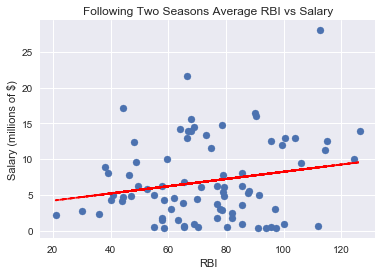

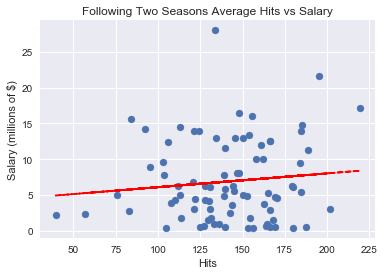

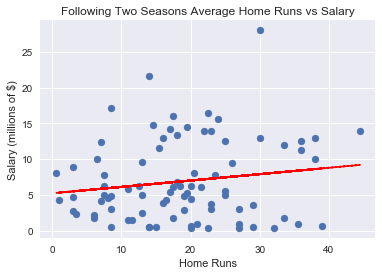

In [30]:
analyze_following_records(batting_following, ['RBI', 'Hits', 'Home Runs'])

As predicted, the correlations have all decreased. A player's salary is not as linearly depedent on performance metrics in the years following the salary as it was on the performance metrics from the years preceding the salary. In summary, here is a chart showing how the correlations between performance metrics and salary change depending on the time span analyzed:

|                      | Previous Two Seasons | Five Season Average | Following Two Seasons |
|:--------------------:|----------------------|---------------------|-----------------------|
| RBI Correlation      |         0.462        |        0.344        |         0.200         |
| Hits Correlation     |         0.332        |        0.238        |         0.110         |
| Home Run Correlation |         0.396        |        0.299        |         0.156         |

As mentioned in the introduction, I think what is being demonstrated here is primarily an example of regression to the mean. Players perform well for two seasons, are awarded a larger contract, and then fail to live up to their earlier numbers in the following seasons. This is intriguing because it means that players that are awarded larger contracts based on their past performance should not be worth as much in the following seasons. Players earn a large contract because of several above-average years of performance, but then their performace  will tend to revert to a more average level of play just as any outlier in a random process will gradually drift back towards the average over a long enough observation span. 

I'll perform a similar analysis of the pitching metrics before I return to the batting stats to conduct a statistical test to test my hypothesis that players with larger salaries will see a decrease in performance from before to after the salary season. 

#### Pitching Analysis

The correlation between average ERA over the five years and salary is -0.127
The correlation between average Wins over the five years and salary is 0.329
The correlation between average Strikeouts over the five years and salary is 0.021


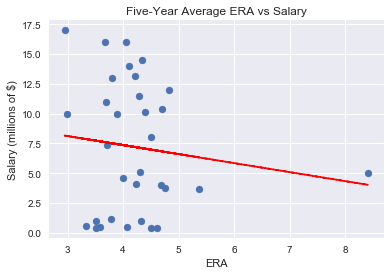

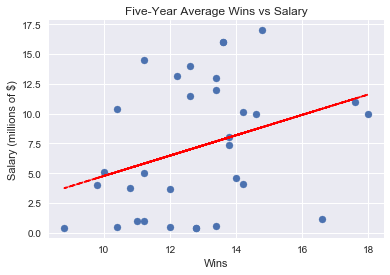

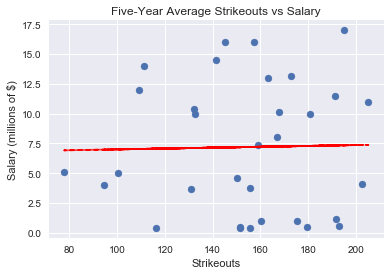

In [31]:
analyze_five_year_records(pitching_five_year, ['ERA', 'Wins' ,'Strikeouts'])

Right away, we can see that the correlation between ERA and salary is slightly negative as expected because a lower Earned Runs Average is better for a pitcher. We can also see that the strongest correlation is between wins and salary. This is what I had predicted because wins are easy for everyone (especially those paying the players) to understand and it just feels "right" to award a pitcher a higher salary if they generate more wins regardless of how good an indicator of a pitchers ability wins actually are. I must offer a word of caution regarding this dataset though. The sample size of 32 is relatively small compared to the 83 samples in the batting dataset. I will go through the same process as I did with the batters and see if the salary correlations are greater in the two seasons preceding the salary year or the following two seasons. 

The correlation between average ERA over the previous two years and salary is -0.252
The correlation between average Wins over the previous two years and salary is 0.473
The correlation between average Strikeouts over the previous two years and salary is 0.288


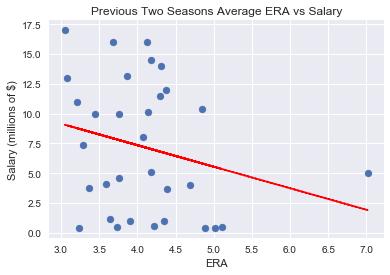

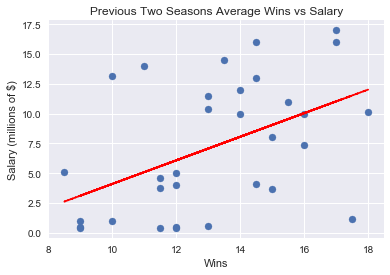

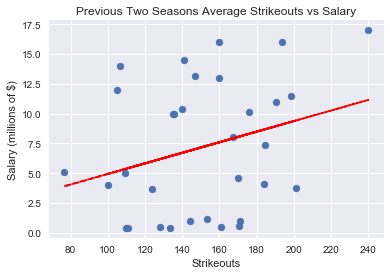

In [32]:
analyze_previous_records(pitching_previous, ['ERA', 'Wins', 'Strikeouts'])

The correlation between average ERA over the following two years and salary is -0.050
The correlation between average Wins over the following two years and salary is -0.050
The correlation between average Strikeouts over the following two years and salary is -0.228


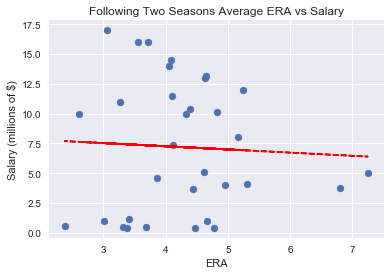

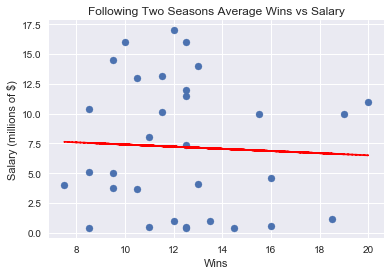

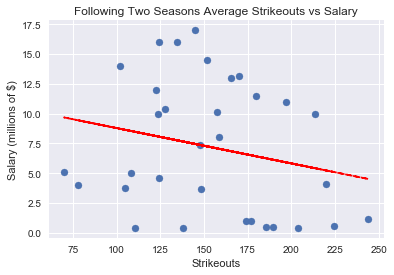

In [33]:
analyze_following_records(pitching_following, ['ERA', 'Wins', 'Strikeouts'])

Regression to the mean strikes again! As was demonstrated in the batting analysis, the two years preceding the salary had a stronger correlation with the salary than the two years following. In fact, wins, which were the most highly correlated metric over the entire five year average, had a negative correlation with 2008 salary in the following two seasons. That means that the more a pitcher had been paid in 2008, the fewer wins he had over the next two seasons! Granted, this dataset is small, and pitching statistics can be heavily influenced by fielding and the performance of the rest of the team (hence the reason for statistics such as [fielding independent pitching](http://www.crawfishboxes.com/2015/4/30/8519577/sabermetrics-10-best-stats-more) used in advanced sabermetrics).Nonetheless, that is still an intriguing result. We see the need for identifying players before they hit their prime seasons so teams can extract more performance from players at a lower price (this is capitalism after all!). Once a player has reached their peak seasons, they will command a higher salary, but then their performance will tend to slip back towards the average and they should not be as highly "valued." Here is a summary of the correlations between pitching performance metrics and salary:


|                        | Previous Two Seasons | Five Season Average | Following Two Seasons |
|:----------------------:|----------------------|---------------------|-----------------------|
| ERA Correlation        |        -0.252        |        -0.127       |         -0.050        |
| Wins Correlation       |         0.473        |        0.329        |         -0.050        |
| Strikeouts Correlation |         0.288        |        0.021        |         -0.228        |



### t-Test

A more rigorous statistical analysis would help to prove whether regression to the mean is at play when examining the relationship between performance metrics and salary over time. In particular, I wanted to see if there existed a statistically significant difference in changes in performance between players with 2008 salaries above the mean, and players with 2008 salaries below the mean. I decided to focus on the batting performance metric of Runs Batted In because that had had the strongest correlation with salary. I knew that I would need to perform an [independent samples t-Test](http://www.statisticshowto.com/independent-samples-t-test/) as I wanted to compare the means of two sets of unrelated data. The mean that I wanted to compare between the two groups was the change in RBIs from the seasons preceding the salary to the years following the salary. I defined the change in RBIs as the following two seasons average RBIs minus the average RBIs from the previous two seasons. $$ \Delta RBI = Average\_RBI\_Following - Average\_RBI\_preceding $$
Therefore, if this was a positive value, that would indicate the player had performed better in the seasons following the salary year, and a negative value would indicate the player had performed worse. If regression to the mean was at work, then the players with salaries above the mean in 2008 would see a smaller $ \Delta RBI $. If there was no regression to the mean, then there would be no significant difference in $ \Delta RBI $ between the players with above average salaries and players with below average salaries. This means that the test would be a one-tailed t-Test as I was testing to see if the means were different in a single direction. 
The null hypothesis can be stated: players with above average salaries in 2008 will have an average $ \Delta RBI $ greater than or equal to the average $ \Delta RBI $ demonstrated by the players with below average salaries in 2008. In mathematical terms this is $$ H_o: \mu_a - \mu_b >= 0 $$ where $ \mu_a $ is the mean $ \Delta RBI $ for players with above average salaries and $ \mu_b $ is the mean $ \Delta RBI $ for players with below average salaries. 
The alternative hypothesis is: players with above average salaries in 2008 will have an average $ \Delta RBI $ less than the average $ \Delta RBI $ of players with below average 2008 salaries. In mathematical terms this is $$ H_o: \mu_a - \mu_b < 0 $$

The steps to perform the t-Test were as follows:
1. Determine an appropriate $ \alpha $ level for the test. I choose $ \alpha = 0.05$
2. Determine t-critical for a one-tailed t-Test with $ degrees\ of\ freedom = group\ 1\ samples + group\ 2\ samples - 2 $
3. Determine the sample mean and standard deviation of $ \Delta RBI $ for players with 2008 salaries above the mean.
4. Determine the sample mean and standard deviation of $ \Delta RBI $ for players with 2008 salaries below the mean.
5. Calculate the difference in means between the two samples. Calculate the standard error using both sample standard deviations normalized by their respective sample sizes. 
6. Calculate the t-statistic : $ t-statistic = \frac{Mean\ difference}{Standard\ error} $
7. Compare the t-statistic to the t-critical value and draw a conclusion regarding the null hypothesis. 
8. Report the results. 

I first needed to create a DataFrame of batters that contained playerIDs, $ \Delta RBI $, and standardized salaries. Standardizing the salaries would allow me to see if a player had a salary above or below the mean. 

In [34]:
# Create a new DataFrame comparing the previous seasons averages to the followins seasons averages
batting_comparison = batting_previous[['playerID', 'Salary']]
batting_comparison.is_copy =False
# Create a column showing the change in RBIs from the previous seasons to the following seasons
batting_comparison['RBI_change'] = batting_following['RBI'] - batting_previous['RBI']

# Standardize the salaries
batting_comparison['Salary_SD'] = (batting_comparison['Salary'] - batting_comparison['Salary'].mean()) / batting_comparison['Salary'].std()
batting_comparison.head()

,playerID,Salary,RBI_change,Salary_SD
0,abreubo01,16000000.0,-13.5,1.609968
1,bautijo02,1800000.0,25.0,-0.898419
2,beltrad01,13400000.0,-21.0,1.150686
3,berkmla01,14500000.0,-50.0,1.344997
4,betanyu01,1550000.0,6.5,-0.942581


The DataFrame looks like what I want. I will now separate it into two DataFrames, one containing players with 2008 salaries above the mean, and one containing 2008 salaries below the mean. 

In [35]:
batting_comparison_above_mean = batting_comparison[batting_comparison['Salary_SD'] > 0]
batting_comparison_below_mean = batting_comparison[batting_comparison['Salary_SD'] < 0]

In [36]:
samples_above_average = len(batting_comparison_above_mean)
samples_below_average = len(batting_comparison_below_mean)
print('There are {} players with a 2008 salary above the mean.'.format(samples_above_average))
print('There are {} players with a 2008 salary below the mean.'.format(samples_below_average))

There are 31 players with a 2008 salary above the mean.
There are 52 players with a 2008 salary below the mean.


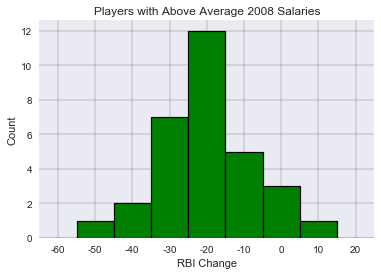

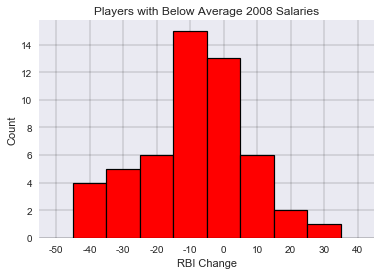

In [37]:
# Plotting the distribution of changes in RBI in the two samples. 
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

bins = range(-60, 40, 10)
plt.figure()
plt.hist(batting_comparison_above_mean['RBI_change'], color='g', bins= bins, edgecolor = 'black', linewidth=1.2)
bins_labels(bins)
plt.title('Players with Above Average 2008 Salaries')
plt.xlabel('RBI Change'); plt.ylabel('Count');
plt.grid(color='k', linewidth=0.2)
bins = range(-50, 60, 10)
plt.figure()
plt.hist(batting_comparison_below_mean['RBI_change'], color = 'r', bins= bins, edgecolor = 'black', linewidth=1.2)
plt.title('Players with Below Average 2008 Salaries')
bins_labels(bins)
plt.xlabel('RBI Change'); plt.ylabel('Count');
plt.grid(color='k', linewidth=0.2)

As can be seen in the histograms, both charts approximate a normal distribution with the $ \Delta RBI $ for the players with 2008 salaries above the mean tending to be skewed more negative. Again, a negative $ \Delta RBI $ indicated the player performed worse in the two seasons following the salary year as compared to the two seasons preceding the salary year.

The one-tailed t-critical statistic for $ \alpha = 0.05 $ with 81 degrees of freedom is -1.664 from the [t-score table](http://applchem.science.unideb.hu/T-Table.pdf). The value is negative as the null hypothesis is stated with respect to change in means in the negative direction.

In [38]:
# Determine both sample means and standard deviations for the change in RBIs.

above_average_mean = batting_comparison_above_mean['RBI_change'].mean()
above_average_std = batting_comparison_above_mean['RBI_change'].std()

below_average_mean = batting_comparison_below_mean['RBI_change'].mean()
below_average_std = batting_comparison_below_mean['RBI_change'].std()

In [39]:
print('The mean change in RBIs for the players with above average salaries was {:0.3f}'.format(above_average_mean))
print('The mean change in RBIs for the players with below average salaries was {:0.3f}'.format(below_average_mean))
print('The standard deviation of the change in RBIs for the players with above average salaries was {:0.3f}'.format(above_average_std))
print('The standard deviation of the change in RBIs for the players with below average salaries was {:0.3f}'.format(below_average_std))

The mean change in RBIs for the players with above average salaries was -14.597
The mean change in RBIs for the players with below average salaries was -3.885
The standard deviation of the change in RBIs for the players with above average salaries was 13.792
The standard deviation of the change in RBIs for the players with below average salaries was 15.990


At this point, it can be seen that both samples of players demonstrated a decrease in RBIs between the preceding and following seasons. However, no conclusion about the statistical significance can yet be drawn.  

In [40]:
standard_error = math.sqrt( ((above_average_std**2)/samples_above_average) + \
                            ((below_average_std**2)/samples_below_average))

In [41]:
t_statistic = (above_average_mean - below_average_mean) / standard_error 

In [42]:
print('The t-statistic is {:0.3f}'.format(t_statistic))

The t-statistic is -3.222


The t-statistic of -3.222 from the t-test is less than the t-critical of -1.664 for $ \alpha = 0.05 $. Therefore, I can reject the null hypothesis and conclude that the players with above average salaries in 2008 experienced a statistically significant decrease in performance relative to players with below average salaries in 2008 from the years preceding the salary to the years following the salary. This shows that regression to the mean was demonstrated as players with greater performance in the two preceding seasons were awarded higher salaries in 2008, but then saw their performance decline in the following two seasons more than the players who earned salaries below the average in 2008.

In more formal terms, the t-test can be summarized as follows:
An independent samples t-Test was conducted to compare the performance changes across seasons of Major League Baseball (MLB) players with above average salaries to those with below average salaries in 2008. There was a statistically significant difference in the change in Runs Batted In (RBIs) for the players with above average salaries (M=-14.597, SD=13.793) as compared to the players with below average salaries (M=-3.885, SD=15.990); t=-3.222, p<.05. These results suggest that players with higher salaries will see a larger decrease in their performance from before the salary year to after the salary year than players with lower salaries. Regression to the mean appears to be at work in MLB, and outliers such as exceptional batting performance as measured in RBIs will tend to return to the mean value given enough time. 

### Machine Learning

As a final part to this analysis, I wanted to perform some basic machine learning on the dataset to see if I could create a model that would be able to predict whether a player would have an above average salary in a year based on the previous two seasons of performance metrics. I decided to stick with salaries from only 2008, but in order to expand my dataset, I would include all players who had recorded complete seasons (defined as playing more than 100 games) in 2006 and 2007 and who had salary date in 2008. I know that machine learning improves as the amount of data fed into the training algorithm improves, so I wanted to get more samples. I would only be using batters, and I would use the three performance metrics of RBIs, home runs, and hits. I would use the sci-kit learn library built-in algorithms for my classifier.   

In [43]:
# testing_set is my new DataFrame that will eventually include the features and labels for machine learning
testing_set = all_batting[['yearID', 'playerID', 'RBI', 'H', 'HR', 'G']]
testing_set = testing_set[(testing_set['yearID'] == 2006) | (testing_set['yearID'] == 2007)]
testing_set = testing_set.merge(salaries_2008, on='playerID')
testing_set = testing_set[testing_set['G'] >= 100]
testing_set = testing_set.groupby(['playerID', 'yearID'], as_index=False).mean()

In [44]:
years_to_examine = [2006, 2007]

# This is a repeat of the function used to find players with records in all five years used in the analysis section.
def find_players_with_all_years(records):
    
    # First create a list with all of the playerIDs (many will be repeated) in the playerID column of the DataFrame
    list_of_IDs = list(records['playerID'])
    players_with_five_years = set()
    
    # Iterate through the list of IDs and count how many times a given ID occurs in the list
    # This will correspond to the number of entries that player has in the records_df
    for player in list_of_IDs:
        if (list_of_IDs.count(player)) == len(years_to_examine):
            players_with_five_years.add(player)
    
    # Return a modified DataFrame that only includes players with records in every year to be examined.
    return records[records['playerID'].isin(players_with_five_years)]

In [45]:
testing_set = find_players_with_all_years(testing_set)

In [46]:
# Average the player statistics across the two years
testing_set = testing_set.groupby('playerID', as_index=False).mean()

In [47]:
testing_set.head()

,playerID,yearID,RBI,H,HR,G,salary
0,amezaal01,2006.5,24.5,96.0,2.5,132.5,945000.0
1,anderga01,2006.5,82.5,138.0,16.5,124.5,12600000.0
2,atkinga01,2006.5,115.5,190.0,27.0,157.0,4387500.0
3,ausmubr01,2006.5,32.0,91.5,2.5,128.0,2000000.0
4,bautijo02,2006.5,57.0,114.5,15.5,129.5,1800000.0


At this point, I have a DataFrame that contains the stats of players who recorded complete seasons in 2006 and 2007 and their salary for 2008. In order to perform [machine learning](http://machinelearningmastery.com/basic-concepts-in-machine-learning/), I needed features or inputs, and a desired label, or output. My three features I selected are RBIs, hits, and home runs averaged across the 2006-2007 seasons. The label will be whether or not the player with the statistics was paid an above average salary in 2008. I once again need to standardized the salaries and then convert them into a 1 or a 0. 1 will be the label given to above average salaries and 0 will be assigned to below average salaries. 

In [48]:
testing_set['salary_sd'] = (testing_set['salary'] - testing_set['salary'].mean()) / testing_set['salary'].std()

In [49]:
testing_set['labels'] = testing_set['salary_sd'] > 0

In [50]:
testing_set['labels'] = testing_set['labels'].astype(int)

In [51]:
testing_set.drop(['yearID', 'playerID', 'G', 'salary'], axis=1, inplace=True)

In [52]:
testing_set.head(8)

,RBI,H,HR,salary_sd,labels
0,24.5,96.0,2.5,-1.048286,0
1,82.5,138.0,16.5,1.140188,1
2,115.5,190.0,27.0,-0.401884,0
3,32.0,91.5,2.5,-0.850187,0
4,57.0,114.5,15.5,-0.887742,0
5,96.5,148.0,28.0,-0.099102,0
6,94.0,165.0,25.5,1.290405,1
7,114.0,146.5,37.0,2.271098,1


Great! It looks like my DataFrame is ready. I have 166 entries, which while not many by machine learning standards, is double the number I had for my full batting analysis. Next, I need to convert to NumPy arrays that can be fed into a classifier. I choose the Gaussian Naive Bayers algorithm for my classifier based on [a flowchart from sci-kit learn](http://scikit-learn.org/stable/tutorial/machine_learning_map/).

In [53]:
#sci-kit learn imports
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [54]:
testing_set.drop('salary_sd', axis=1, inplace=True)

In [55]:
# Customary to name the features X and the labels y
X = np.array(testing_set.drop('labels', axis=1))
y = np.array(testing_set['labels'])

In [56]:
# Preprocessing
X = scale(X)

In [57]:
# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [58]:
# Create the classifier and train on the training set
gnb = GaussianNB()
gnb.fit(X_train, y_train);

In [59]:
# Test the classifier on the testing set of data
accuracy = gnb.score(X_test, y_test)
print(accuracy)

0.642857142857


Based on this, I can see that the classifier is able to correctly predict with a better than chance accuracy whether a player will have an above average salary in 2008 based on the number of RBIs, home runs, and hits from the previous two seasons! I will train and test the classifier 100 times to get a better average prediction rate.`

In [60]:
num_training_runs = 100
accuracy = []
for i in range(num_training_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    gnb.fit(X_train, y_train)
    accuracy.append(gnb.score(X_test, y_test))
    
print('The average accuracy after {} training runs was {:0.2f}%.'.format(num_training_runs, 100*np.mean(accuracy)))

The average accuracy after 100 training runs was 70.24%.


This prediction rate is certainly not stellar, but it is better than chance. The classifier would benefit from more data, and maybe more features as well. As we have already seen, none of the three performance metrics analyzed in this report were very strongly correlated with salary, and there may be others that are a better predictor of salary. Further work could be done to determine the features (performance characteristics) that could indicate with a greater accuracy whether or not a player will command a higher than average salary. This was a minor foray into machine learning, but it demonstrated that even with a limited amount of data, a machine learning approach can make predictions with an accuracy higher than chance guessing. 

### Conclusion

There are several conclusions that can be drawn from this analysis but there are also numerous caveats that must be mentioned that prevent these conclusions from being accepted as fact. I also must state the ever-present rule that correlation does not imply causation. In other words, players statistics may be correlated with salary, but that does not mean the statistics caused a higher or a lower salary.

The main conclusions are as follows:

1. When looking at batters from the range 2006-2010, the number of RBIs was the performance metric most highly correlated with salary in 2008.
2. When looking at pitchers from the range 2006-2010, the number of wins was the performance metric most highly correlated with salary in 2008. 
3. These correlations were stronger in the two seasons preceding 2008 than in the two seasons following 2008. A t-Test conducted on batters found that batters with an above average salary in 2008 exhibited larger declines in performance (as measured by number of RBIs) from the preceding seasons to the following seasons than players with a below average salary in 2008. This strongly suggests that players with an above average salary experience a regression to the mean in terms of performance. 
4. Based on the above point, teams should make an effort to discover players before they have a breakout season. That is basically what the Oakland Athletics management team, the subject of the book _Moneyball_, did in the early 2000s, and they were able to compete and beat teams with much greater player salaries. [By finding players who were undervalued](http://grantland.com/features/the-economics-moneyball/), they were able to achieve sustained success despite their meager payroll. Once a player has reached the level where they command a higher salary, they will tend to not perform as well as before their salary increased because their prior performance was an outlier and will gradually decline to a more average level. This phenomenon is not limited to baseball, but can be observed in all aspects of daily life as [shown by numerous researchers](https://academic.oup.com/ije/article/34/1/215/638499/Regression-to-the-mean-what-it-is-and-how-to-deal#10889752).

Besides the ever-important rule that correlation does not equal causation, there were several other limitations to the data analysis. The main caveats I was able to identify are as follows:

1. The size of the data. This is probably the most important to mention. After applying my various requirements to the datasets, I was left with 83 batters to analyze and only 32 pitchers. In order to account for this, I could analyze more salary years, or lower the requirements for a player to be in the dataset which might then have other additional effects on the analysis.
2. The age of players. As a player gets older and accumulates more years spent in the league, their salary tends to increase even if their performance does not. I did not control for the age of the players in the analysis. 
3. There is inherent randomness in baseball stats from season to season. Some years are [better pitching years](http://www.thisgreatgame.com/1968-baseball-history.html) and some years are better for batters. Statistics can also vary widely between ballparks due to the geometry of the park or even the [density of the air](http://baseball.physics.illinois.edu/Denver.html) as is observed at the home of the Colorado Rockies. I did not control for the players home ballpark, team, or league in which the player accumulated their statistics. 
4. Post-season performances may factor more heavily into a player's salary than during the regular season. A memorable performance in the World Series may do more to boost a player's salary than several years of above average play during the regular season. A more thorough analysis would look at the relative impacts on salary of post-season performance compared to the regular season. Moreover, as mentioned before, I was looking at relatively basic statistics that have proven to not be the most effective measures of player performance. For example, a pitcher's number of wins will depend heavily on factors such as the fielding of the team and the general ability of the other players on the team. This is why sabermetricians typically deal with advanced statistics derived from the more basic metrics. These measures attempt to account for all the different factors that might play into a single number such as hits. One of the more effective measures of perforamance is known as [Wins Above Replacement (WAR)](http://www.fangraphs.com/library/misc/war/) which assigns a number to a player representing how many wins they contributed to their team versus what an average player would have generated. WAR for batters takes into account at least 8 separate statistics!

In summary, this project demonstrated the entire process of investigating a dataset including: posing questions about a dataset, wrangling the data into a usable format, analyzing the data, and extracting applicable conclusions from the data. I was also able to apply a statistical test to my dataset as well as take a short excursion into the realm of machine learning to see if an algorithm was able to make predictions that model the real world. 